In [1]:
import faulthandler 
from pyspark.sql import SparkSession 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DateType, FloatType, TimestampType
from pyspark.sql.functions import col, array_contains, isnan, when, count
from pyspark.sql.functions import lit, concat_ws, concat, collect_list, udf
from pyspark.sql.functions import countDistinct
import plotly.express as px
from sklearn.preprocessing import RobustScaler
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from tqdm import tqdm
from scipy.stats import gmean

In [2]:

# spark = SparkSession.builder.master('local').appName('Python Spark SQL Practice').getOrCreate()
# Spark 세션 최적화
spark = SparkSession.builder \
    .appName("Ecommerce Reward Processing") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "4") \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .getOrCreate()

In [3]:
def search(dirname):
    filenames = os.listdir(dirname)
    file_list = []
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        print(full_filename)
        file_list.append(full_filename)
    return file_list
data_path_list = search("D:/workspace/data/")

D:/workspace/data/2019-Dec.csv
D:/workspace/data/2019-Nov.csv
D:/workspace/data/2019-Oct.csv
D:/workspace/data/2020-Apr.csv
D:/workspace/data/2020-Feb.csv
D:/workspace/data/2020-Jan.csv
D:/workspace/data/2020-Mar.csv


In [4]:
schema = StructType() \
      .add("event_time",TimestampType(),True) \
      .add("event_type",StringType(),True) \
      .add("product_id",StringType(),True) \
      .add("category_id",StringType(),True) \
      .add("category_code",StringType(),True) \
      .add("brand",StringType(),True) \
      .add("price",DoubleType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_session",StringType(),True)

In [5]:
for i, x in enumerate(data_path_list):
    file_path = x
    df = spark.read.format("csv") \
      .option("header", True) \
      .option('delimiter', ',') \
      .schema(schema) \
      .load(file_path)
    if i == 0:
        merged_df = df
    else:
        merged_df = merged_df.union(df)

In [6]:
merged_df.show()

+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-12-01 09:00:00|      view|   1005105|2232732093077520756|construction.tool...|  apple|1302.48|556695836|ca5eefc5-11f9-450...|
|2019-12-01 09:00:00|      view|  22700068|2232732091643068746|                NULL|  force| 102.96|577702456|de33debe-c7bf-44e...|
|2019-12-01 09:00:01|      view|   2402273|2232732100769874463|appliances.person...|  bosch| 313.52|539453785|5ee185a7-0689-4a3...|
|2019-12-01 09:00:02|  purchase|  26400248|2053013553056579841|computers.periphe...|   NULL| 132.31|535135317|61792a26-672f-4e6...|
|2019-12-01 09:00:02|      view|  20100164|2232732110089618156|    apparel.t

In [7]:
merged_df.createOrReplaceTempView("ecommerce")

In [8]:
purchases = spark.sql("""
    SELECT * 
    FROM ecommerce
    WHERE event_type = 'purchase'
""")
purchases.createOrReplaceTempView("purchases")

In [9]:
purchases = spark.sql("""
    SELECT *,
        CAST(event_time AS TIMESTAMP) AS event_timestamp,
        YEAR(event_time) AS year,
        MONTH(event_time) AS month,
        WEEKOFYEAR(event_time) AS week,
        DAY(event_time) AS day,
        HOUR(event_time) AS hour,
        MINUTE(event_time) AS minute,
        SECOND(event_time) AS second
    FROM purchases
""")
purchases.createOrReplaceTempView("purchases_transformed")

In [10]:
df_user_stats = spark.sql("""
    SELECT 
        user_id,
        SUM(price) AS total_spent,
        COUNT(product_id) AS total_purchases,
        AVG(price) AS avg_purchase_price,
        MIN(event_timestamp) AS first_purchase,
        MAX(event_timestamp) AS last_purchase,
        DATEDIFF(MAX(event_timestamp), MIN(event_timestamp)) AS days_between_purchases
    FROM purchases_transformed
    GROUP BY user_id
""")

In [ ]:
df_user_stats = spark.sql("""
    SELECT 
        user_id,
        SUM(price) AS total_spent,
        COUNT(product_id) AS total_purchases,
        AVG(price) AS avg_purchase_price,
        DATEDIFF(MAX(event_timestamp), MIN(event_timestamp)) AS days_between_purchases
    FROM purchases_transformed
    GROUP BY user_id
""")

In [11]:
# 매출 성장률 가정
growth_rates = [0.10, 0.20, 0.30]
reward_options = [1, 2, 5, 10]

In [12]:
simulation_results = []

# PySpark DataFrame → Pandas 변환 (for 문 사용을 위함)
user_stats_pd = df_user_stats.toPandas()

In [15]:
user_stats_pd.to_csv("전처리데이터for시뮬.csv", index=False)

In [13]:


# 시뮬레이션 실행 (GitHub 코드 방식과 동일)
for growth_rate in tqdm(growth_rates):
    for reward in reward_options:
        # 예상 매출 증가 적용
        user_stats_pd["new_revenue"] = user_stats_pd["total_spent"] * (1 + growth_rate)

        # 리워드 비용 적용 (1000명에게 지급 가정)
        user_stats_pd["reward_cost"] = reward * 1000

        # 순이익 계산
        user_stats_pd["net_profit"] = user_stats_pd["new_revenue"] - user_stats_pd["reward_cost"]

        # 수익성이 있는 경우만 저장
        profitable_rewards = user_stats_pd[user_stats_pd["net_profit"] > 0]
        simulation_results.append(profitable_rewards)

# 결과 병합
final_results = pd.concat(simulation_results, ignore_index=True)

100%|██████████| 3/3 [00:00<00:00,  4.82it/s]


In [17]:
final_results.to_csv("시뮬레이션 결과.csv")

In [1]:
import multiprocessing

print(f"사용 가능한 CPU 코어 수: {multiprocessing.cpu_count()}")

사용 가능한 CPU 코어 수: 12


In [ ]:
import time
from multiprocessing import Pool


def square(n):
    time.sleep(1)  # 일부러 지연 (부하 확인용)
    return n * n

if __name__ == "__main__":
    numbers = list(range(10))
    num_workers = min(multiprocessing.cpu_count(), 4)  # 최대 4개 프로세스 사용

    # 병렬 처리 실행
    with Pool(num_workers) as pool:
        start_time = time.time()
        results = pool.map(square, numbers)
        end_time = time.time()

    print(f"병렬 처리 결과: {results}")
    print(f"실행 시간: {end_time - start_time:.2f} 초")

In [16]:
data = spark.sql("""
                 SELECT user_id, event_time, price, event_type
                 FROM ecommerce
                 WHERE event_type = 'purchase'


""").toPandas()

In [17]:
data.to_csv("전처리데이터for시뮬레이션.csv", index = False)

In [14]:
# # # 데이터 로드 (업로드된 CSV 파일 사용)
file_path = 'rfm_20Q1.csv'
data = pd.read_csv(file_path)

In [8]:
file_path = 'RFM_SCORE.csv'
data = pd.read_csv(file_path)

In [9]:
data

,user_id,Recency,Frequency,Monetary,Recency_score,Monetary_score,Frequency_score
0,568782581,53,2120,540447,2,3,3
1,549109608,25,1383,750149,3,3,3
2,513230794,40,1373,647798,2,3,3
3,513320236,3,1159,567148,3,3,3
4,598224683,1,1059,539601,3,3,3
...,...,...,...,...,...,...,...
2064894,635125080,30,1,170,3,2,1
2064895,488893876,30,1,407,3,2,1
2064896,633361079,30,1,421,3,2,1
2064897,635075963,30,1,423,3,2,1


In [10]:

# RFM 분석 실행
def calculate_rfm(data):
    rfm = data
    
    # 분위수 기반 점수 부여
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])
    
    # RFM 점수 조합
    rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
    return rfm

rfm = calculate_rfm(data)

100%|██████████| 2000/2000 [09:09<00:00,  3.64it/s]


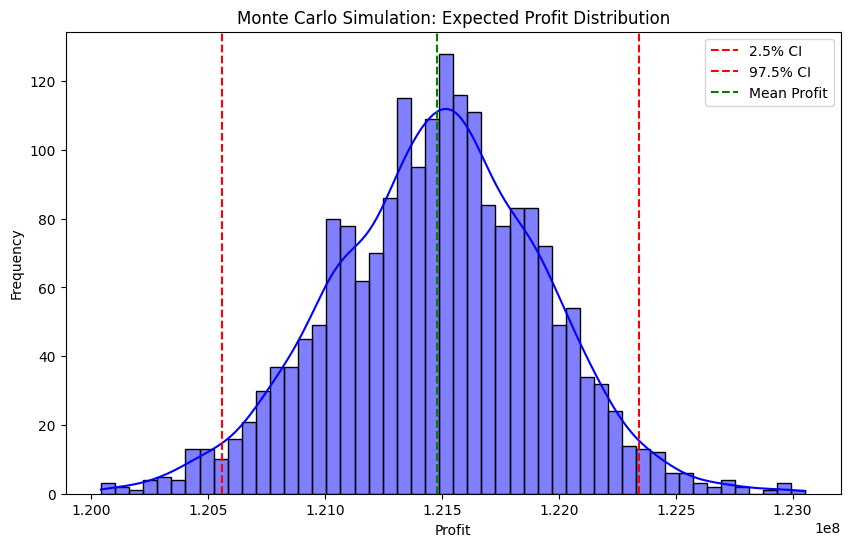

Expected Profit: 121477454.69
95% Confidence Interval: (120557009.23, 122344721.25)


In [14]:
from tqdm import tqdm





# VIP 및 충성 고객 식별
vip_customers = rfm[rfm['RFM_Score'] >= 10]

# Monte Carlo 시뮬레이션 함수
def simulate_promotion(iterations=2000):
    np.random.seed(42)
    results = []
    base_profit = data['Monetary'].sum() * 0.10  # 영업이익 (10%)
    promo_cost_ratio = 0.30  # 프로모션 할인율 (5%)
    response_rate = 0.30  # 프로모션 응답률 (20%)
    
    for _ in tqdm(range(iterations)):
        responding_customers = vip_customers.sample(frac=response_rate, replace=False)
        additional_sales = responding_customers['Monetary'].mean() * len(responding_customers)
        additional_profit = additional_sales * 0.10
        promo_cost = additional_sales * promo_cost_ratio
        net_profit = base_profit + additional_profit - promo_cost
        results.append(net_profit)
    
    return results

# 병렬 처리 실행
# def run_monte_carlo_parallel(iterations=2000, workers=4):
#     with Pool(workers) as pool:
#         chunk_size = iterations // workers
#         results = pool.map(simulate_promotion, [chunk_size] * workers)
#     return np.concatenate(results)

# sim_results = run_monte_carlo_parallel()

sim_results = simulate_promotion()

# 결과 시각화
plt.figure(figsize=(10, 6))
sns.histplot(sim_results, bins=50, kde=True, color='blue')
plt.axvline(np.percentile(sim_results, 2.5), color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(np.percentile(sim_results, 97.5), color='red', linestyle='dashed', label='97.5% CI')
plt.axvline(np.mean(sim_results), color='green', linestyle='dashed', label='Mean Profit')
plt.title('Monte Carlo Simulation: Expected Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 평균 및 신뢰구간 출력
mean_profit = np.mean(sim_results)
ci_lower, ci_upper = np.percentile(sim_results, [2.5, 97.5])
print(f"Expected Profit: {mean_profit:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

In [18]:
print(f"{round((mean_profit - data['Monetary'].sum() * 0.10)/ data['Monetary'].sum() * 0.10 *100,2)} %")

-0.41 %


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product

# VIP 및 충성 고객 식별
vip_customers = rfm[rfm['RFM_Score'] >= 10]

# 몬테카를로 시뮬레이션 함수
def simulate_promotion(promo_cost_ratio, response_rate, iterations=2000):
    np.random.seed(42)
    results = []
    base_profit = data['Monetary'].sum() * 0.10  # 영업이익 (10%)
    
    for _ in tqdm(range(iterations), desc=f"Simulating promo {promo_cost_ratio:.2f}, response {response_rate:.2f}"):
        responding_customers = vip_customers.sample(frac=response_rate, replace=False)
        additional_sales = responding_customers['Monetary'].mean() * len(responding_customers)
        additional_profit = additional_sales * 0.10
        promo_cost = additional_sales * promo_cost_ratio
        net_profit = base_profit + additional_profit - promo_cost
        results.append(net_profit)
    
    return np.mean(results), np.percentile(results, [2.5, 97.5])

# 다양한 프로모션 설정 실행
promo_cost_ratios = np.linspace(0.01, 0.50, 10)  # 1% ~ 50% (10구간)
response_rates = np.linspace(0.05, 0.60, 12)  # 5% ~ 60% (12구간)

results_list = []
for promo_cost, response in product(promo_cost_ratios, response_rates):
    mean_profit, ci = simulate_promotion(promo_cost, response)
    results_list.append([promo_cost, response, mean_profit, ci[0], ci[1]])

# 결과 데이터프레임 생성 및 시각화
df_results = pd.DataFrame(results_list, columns=['Promo Cost Ratio', 'Response Rate', 'Mean Profit', 'CI Lower', 'CI Upper'])



Simulating promo 0.50, response 0.60: 100%|██████████| 2000/2000 [02:16<00:00, 14.68it/s]


     Promo Cost Ratio  Response Rate   Mean Profit      CI Lower  \
0                0.01           0.05  2.119559e+08  2.117803e+08   
1                0.01           0.10  2.182740e+08  2.180299e+08   
2                0.01           0.15  2.245864e+08  2.242867e+08   
3                0.01           0.20  2.308970e+08  2.305525e+08   
4                0.01           0.25  2.372052e+08  2.368275e+08   
..                ...            ...           ...           ...   
115              0.50           0.40 -1.878443e+07 -2.070811e+07   
116              0.50           0.45 -4.683888e+07 -4.877101e+07   
117              0.50           0.50 -7.488325e+07 -7.680708e+07   
118              0.50           0.55 -1.029374e+08 -1.048139e+08   
119              0.50           0.60 -1.309904e+08 -1.328956e+08   

         CI Upper  Growth Rate  
0    2.121539e+08         3.07  
1    2.185479e+08         6.14  
2    2.249042e+08         9.21  
3    2.312679e+08        12.28  
4    2.375979e+08 

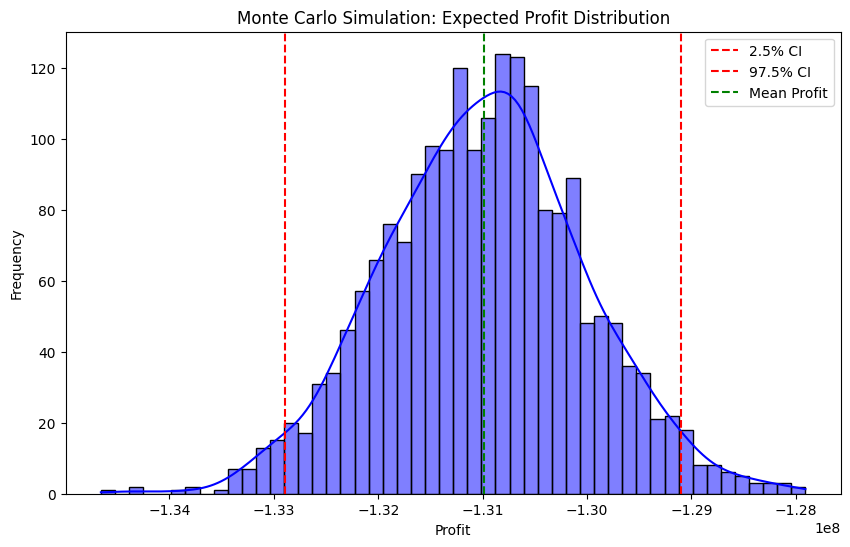

Expected Profit: -130990428.04
95% Confidence Interval: (-132895589.53, -129102422.94)
Growth Rate: -163.7 %


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product

# VIP 및 충성 고객 식별
vip_customers = rfm[rfm['RFM_Score'] >= 10]

# 몬테카를로 시뮬레이션 함수
def simulate_promotion(promo_cost_ratio, response_rate, iterations=2000):
    np.random.seed(42)
    results = []
    base_profit = data['Monetary'].sum() * 0.10  # 영업이익 (10%)
    
    for _ in tqdm(range(iterations), desc=f"Simulating promo {promo_cost_ratio:.2f}, response {response_rate:.2f}"):
        responding_customers = vip_customers.sample(frac=response_rate, replace=False)
        additional_sales = responding_customers['Monetary'].mean() * len(responding_customers)
        additional_profit = additional_sales * 0.10
        promo_cost = additional_sales * promo_cost_ratio
        net_profit = base_profit + additional_profit - promo_cost
        results.append(net_profit)
    
    return results

# 다양한 프로모션 설정 실행
promo_cost_ratios = np.linspace(0.01, 0.50, 10)  # 1% ~ 50% (10구간)
response_rates = np.linspace(0.05, 0.60, 12)  # 5% ~ 60% (12구간)

results_list = []
for promo_cost, response in product(promo_cost_ratios, response_rates):
    sim_results = simulate_promotion(promo_cost, response)
    mean_profit = np.mean(sim_results)
    ci_lower, ci_upper = np.percentile(sim_results, [2.5, 97.5])
    growth_rate = round((mean_profit - data['Monetary'].sum() * 0.10) / (data['Monetary'].sum() * 0.10) * 100, 2)
    results_list.append([promo_cost, response, mean_profit, ci_lower, ci_upper, growth_rate])

# 결과 데이터프레임 생성 및 시각화
df_results = pd.DataFrame(results_list, columns=['Promo Cost Ratio', 'Response Rate', 'Mean Profit', 'CI Lower', 'CI Upper', 'Growth Rate'])

print(df_results)

# 결과 시각화
plt.figure(figsize=(10, 6))
sns.histplot(sim_results, bins=50, kde=True, color='blue')
plt.axvline(np.percentile(sim_results, 2.5), color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(np.percentile(sim_results, 97.5), color='red', linestyle='dashed', label='97.5% CI')
plt.axvline(np.mean(sim_results), color='green', linestyle='dashed', label='Mean Profit')
plt.title('Monte Carlo Simulation: Expected Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 평균 및 신뢰구간 출력
print(f"Expected Profit: {mean_profit:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")

# 성장률 출력
print(f"Growth Rate: {growth_rate} %")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import norm
from multiprocessing import Pool

# # # 데이터 로드 (업로드된 CSV 파일 사용)
# file_path = '전처리데이터for시뮬.csv'
# data = pd.read_csv(file_path)

# 데이터 전처리
# 날짜 데이터 변환
data['event_time'] = pd.to_datetime(data['event_time'])

# 구매 데이터만 필터링
purchase_data = data[data['event_type'] == 'purchase']

# 최신 날짜 계산 (기준: 2020년 3월 31일)
latest_date = purchase_data['event_time'].max()

# RFM 분석 실행
def calculate_rfm(purchase_data, latest_date):
    rfm = purchase_data.groupby('user_id').agg({
        'event_time': lambda x: (latest_date - x.max()).days,
        'user_id': 'count',
        'price': 'sum'
    }).rename(columns={
        'event_time': 'Recency',
        'user_id': 'Frequency',
        'price': 'Monetary'
    })
    
    # 분위수 기반 점수 부여
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])
    
    # RFM 점수 조합
    rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
    return rfm

rfm = calculate_rfm(purchase_data, latest_date)










# VIP 및 충성 고객 식별
vip_customers = rfm[rfm['RFM_Score'] >= 10]

# Monte Carlo 시뮬레이션 함수
def simulate_promotion(iterations=2000):
    np.random.seed(42)
    results = []
    base_profit = purchase_data['price'].sum() * 0.10  # 영업이익 (10%)
    promo_cost_ratio = 0.05  # 프로모션 할인율 (5%)
    response_rate = 0.20  # 프로모션 응답률 (20%)
    
    for _ in tqdm(range(iterations)):
        responding_customers = vip_customers.sample(frac=response_rate, replace=False)
        additional_sales = responding_customers['Monetary'].mean() * len(responding_customers)
        additional_profit = additional_sales * 0.10
        promo_cost = additional_sales * promo_cost_ratio
        net_profit = base_profit + additional_profit - promo_cost
        results.append(net_profit)
    
    return results

# 병렬 처리 실행
# def run_monte_carlo_parallel(iterations=2000, workers=4):
#     with Pool(workers) as pool:
#         chunk_size = iterations // workers
#         results = pool.map(simulate_promotion, [chunk_size] * workers)
#     return np.concatenate(results)

# sim_results = run_monte_carlo_parallel()
sim_results = simulate_promotion()
# 결과 시각화
plt.figure(figsize=(10, 6))
sns.histplot(sim_results, bins=50, kde=True, color='blue')
plt.axvline(np.percentile(sim_results, 2.5), color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(np.percentile(sim_results, 97.5), color='red', linestyle='dashed', label='97.5% CI')
plt.axvline(np.mean(sim_results), color='green', linestyle='dashed', label='Mean Profit')
plt.title('Monte Carlo Simulation: Expected Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 평균 및 신뢰구간 출력
mean_profit = np.mean(sim_results)
ci_lower, ci_upper = np.percentile(sim_results, [2.5, 97.5])
print(f"Expected Profit: {mean_profit:.2f}")
print(f"95% Confidence Interval: ({ci_lower:.2f}, {ci_upper:.2f})")


Simulating promo 0.01, response 0.20, reward 0.01: 100%|██████████| 2000/2000 [09:22<00:00,  3.56it/s]
Simulating promo 0.01, response 0.20, reward 0.06: 100%|██████████| 2000/2000 [08:05<00:00,  4.12it/s]
Simulating promo 0.01, response 0.20, reward 0.10: 100%|██████████| 2000/2000 [08:05<00:00,  4.12it/s]
Simulating promo 0.01, response 0.20, reward 0.15: 100%|██████████| 2000/2000 [08:04<00:00,  4.12it/s]
Simulating promo 0.01, response 0.20, reward 0.20: 100%|██████████| 2000/2000 [08:05<00:00,  4.12it/s]
Simulating promo 0.06, response 0.20, reward 0.01: 100%|██████████| 2000/2000 [08:06<00:00,  4.11it/s]
Simulating promo 0.06, response 0.20, reward 0.06: 100%|██████████| 2000/2000 [08:06<00:00,  4.11it/s]
Simulating promo 0.06, response 0.20, reward 0.10: 100%|██████████| 2000/2000 [08:05<00:00,  4.12it/s]
Simulating promo 0.06, response 0.20, reward 0.15: 100%|██████████| 2000/2000 [08:05<00:00,  4.12it/s]
Simulating promo 0.06, response 0.20, reward 0.20: 100%|██████████| 2000/


Promotion Simulation Results:
    Promo Cost Ratio  Response Rate  Reward Ratio   Mean Profit  \
0           0.010000            0.2          0.01  2.103130e+08   
5           0.064444            0.2          0.01  2.077638e+08   
15          0.173333            0.2          0.01  2.026655e+08   
10          0.118889            0.2          0.01  2.052147e+08   
25          0.282222            0.2          0.01  1.975672e+08   
30          0.336667            0.2          0.01  1.950180e+08   
20          0.227778            0.2          0.01  2.001164e+08   
35          0.391111            0.2          0.01  1.924689e+08   
40          0.445556            0.2          0.01  1.899197e+08   
45          0.500000            0.2          0.01  1.873706e+08   

    Growth Profit  Base Profit    Reward Cost    Optimality  
0    4.682130e+06  205642556.4  204003.823086  2.011644e+08  
5    4.682130e+06  205642556.4  204003.823086  2.011644e+08  
15   4.682130e+06  205642556.4  204003.823086

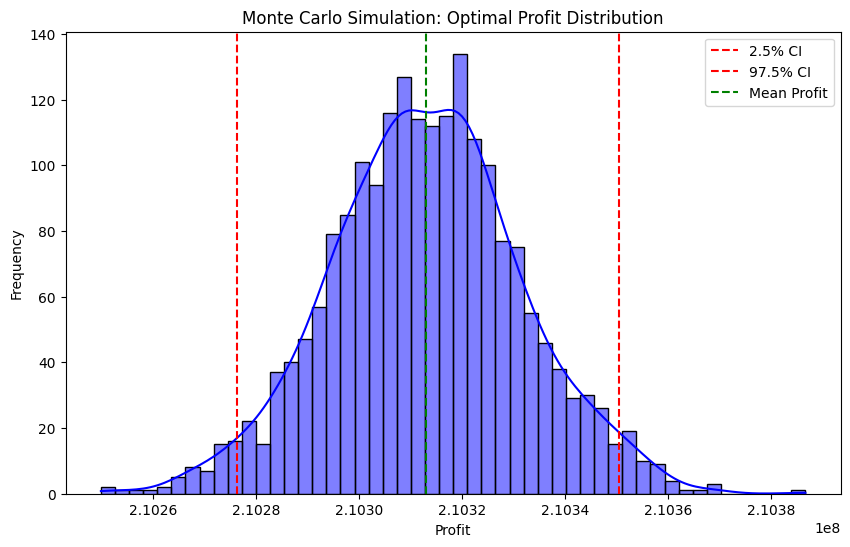

Expected Profit: 210312992.10
95% Confidence Interval: (210276316.36, 210350505.60)

Optimal Reward Combination:
Promo Cost Ratio: 0.01
Response Rate: 0.20
Reward Ratio: 0.01
Mean Profit: 210312992.10
Growth Profit: 4682129.64
Base Profit: 205642556.40
Reward Cost: 204003.82


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from itertools import product

# RFM 분석 실행
def calculate_rfm(data):
    rfm = data[['user_id', 'Recency', 'Frequency', 'Monetary']].copy()
    rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
    rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
    rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
    rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
    return rfm

# 고객 등급 분류
def customer_grade(df):
    df['grade'] = '기타 고객'
    df.loc[(df['R_Score'] >= 3) & (df['F_Score'] >= 3) & (df['M_Score'] >= 3), 'grade'] = 'VIP 고객'
    df.loc[(df['F_Score'] == 4) & (df['R_Score'] >= 2) & (df['M_Score'] >= 2), 'grade'] = '충성 고객'
    return df

# 몬테카를로 시뮬레이션 함수
def simulate_promotion(df, promo_cost_ratio, response_rate, reward_ratio, base_profit, iterations=2000):
    np.random.seed(42)
    results = []
    
    for _ in tqdm(range(iterations), desc=f"Simulating promo {promo_cost_ratio:.2f}, response {response_rate:.2f}, reward {reward_ratio:.2f}"):
        additional_sales = promo_cost = reward_cost = 0
        
        for customer_type, promo_discount, reward_discount in [('VIP 고객', promo_cost_ratio, reward_ratio), ('충성 고객', promo_cost_ratio - 0.05, reward_ratio - 0.02)]:
            responding_customers = df[df['grade'] == customer_type].sample(frac=response_rate, replace=False).reset_index(drop=True)
            if not responding_customers.empty:
                avg_order_value = responding_customers['Monetary'].sum() / responding_customers['Frequency'].sum()
                sales = avg_order_value * len(responding_customers) * 1.2
                additional_sales += sales
                promo_cost += sales * promo_discount
                reward_cost += sales * reward_discount
        
        additional_profit = additional_sales * 0.10
        net_profit = base_profit + additional_profit - promo_cost - reward_cost
        results.append((net_profit, additional_profit, base_profit, reward_cost))
    
    return results

# 데이터 준비 및 시뮬레이션 실행
rfm = customer_grade(rfm)
base_profit = rfm['Monetary'].sum() * 0.10

promo_cost_ratios = np.linspace(0.01, 0.50, 10)
response_rates = [0.2]
reward_ratios = np.linspace(0.01, 0.20, 5)

results_list = []
for promo_cost, response, reward in product(promo_cost_ratios, response_rates, reward_ratios):
    sim_results = simulate_promotion(rfm, promo_cost, response, reward, base_profit)
    mean_profit, additional_profit, _, reward_cost = map(np.mean, zip(*sim_results))
    optimality = abs((additional_profit - base_profit - reward_cost))
    results_list.append([promo_cost, response, reward, mean_profit, additional_profit, base_profit, reward_cost, optimality])

# 결과 데이터프레임 생성 및 최적 조합 탐색
df_results = pd.DataFrame(results_list, columns=['Promo Cost Ratio', 'Response Rate', 'Reward Ratio', 'Mean Profit', 'Growth Profit', 'Base Profit', 'Reward Cost', 'Optimality'])
df_results['Profit Deviation'] = abs(df_results['Base Profit'] - df_results['Mean Profit'])
df_results['Profit'] = df_results['Base Profit'] - df_results['Mean Profit']
df_results = df_results.sort_values(by='Profit Deviation')


Simulating promo 0.06, response 0.20, reward 0.06: 100%|██████████| 2000/2000 [08:41<00:00,  3.83it/s]



Promotion Simulation Results:
    Promo Cost Ratio  Response Rate  Reward Ratio   Mean Profit  \
6           0.064444            0.2        0.0575  2.055398e+08   
2           0.010000            0.2        0.1050  2.058650e+08   
10          0.118889            0.2        0.0100  2.052147e+08   
3           0.010000            0.2        0.1525  2.036410e+08   
5           0.064444            0.2        0.0100  2.077638e+08   
7           0.064444            0.2        0.1050  2.033158e+08   
1           0.010000            0.2        0.0575  2.080890e+08   
11          0.118889            0.2        0.0575  2.029907e+08   
15          0.173333            0.2        0.0100  2.026655e+08   
4           0.010000            0.2        0.2000  2.014169e+08   

    Growth Profit  Base Profit   Reward Cost    Optimality  Profit Deviation  \
6    4.682130e+06  205642556.4  2.428015e+06  2.033884e+08      1.027353e+05   
2    4.682130e+06  205642556.4  4.652027e+06  2.056125e+08      2.22412

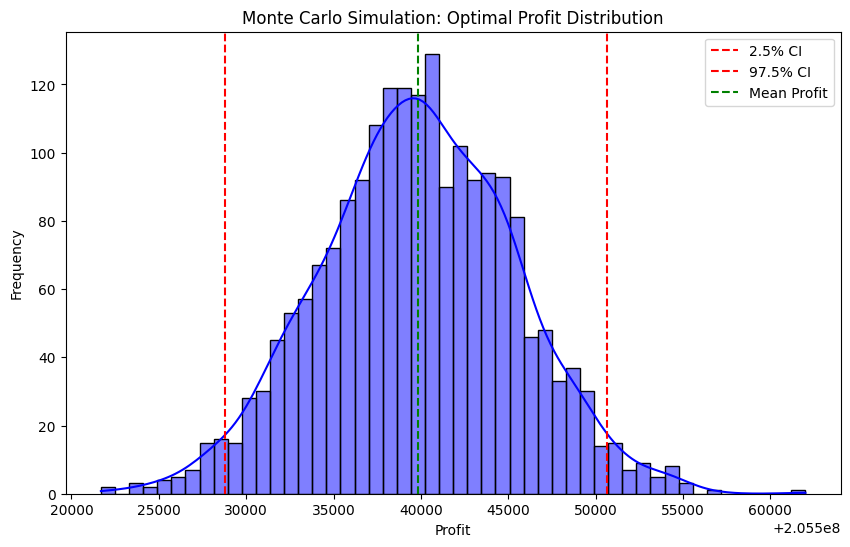

Expected Profit: 205539821.06
95% Confidence Interval: (205528806.47, 205550634.00)

Optimal Reward Combination:
Promo Cost Ratio: 0.06
Response Rate: 0.20
Reward Ratio: 0.06
Mean Profit: 205539821.06
Growth Profit: 4682129.64
Base Profit: 205642556.40
Reward Cost: 2428015.40


In [31]:

# 최적 조합 기반 시뮬레이션 실행
optimal_solution = df_results.iloc[0]
best_promo_cost, best_response, best_reward = optimal_solution[['Promo Cost Ratio', 'Response Rate', 'Reward Ratio']]
best_sim_results = simulate_promotion(rfm, best_promo_cost, best_response, best_reward, base_profit)

# 결과 출력
print("\nPromotion Simulation Results:")
print(df_results.head(10))

# 결과 시각화
plt.figure(figsize=(10, 6))
sns.histplot([r[0] for r in best_sim_results], bins=50, kde=True, color='blue')
plt.axvline(np.percentile([r[0] for r in best_sim_results], 2.5), color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(np.percentile([r[0] for r in best_sim_results], 97.5), color='red', linestyle='dashed', label='97.5% CI')
plt.axvline(np.mean([r[0] for r in best_sim_results]), color='green', linestyle='dashed', label='Mean Profit')
plt.title('Monte Carlo Simulation: Optimal Profit Distribution')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 평균 및 신뢰구간 출력
print(f"Expected Profit: {np.mean([r[0] for r in best_sim_results]):.2f}")
print(f"95% Confidence Interval: ({np.percentile([r[0] for r in best_sim_results], 2.5):.2f}, {np.percentile([r[0] for r in best_sim_results], 97.5):.2f})")

# 최적의 리워드 조합 결과 출력
print(f"\nOptimal Reward Combination:")
print(f"Promo Cost Ratio: {optimal_solution['Promo Cost Ratio']:.2f}")
print(f"Response Rate: {optimal_solution['Response Rate']:.2f}")
print(f"Reward Ratio: {optimal_solution['Reward Ratio']:.2f}")
print(f"Mean Profit: {optimal_solution['Mean Profit']:.2f}")
print(f"Growth Profit: {optimal_solution['Growth Profit']:.2f}")
print(f"Base Profit: {optimal_solution['Base Profit']:.2f}")
print(f"Reward Cost: {optimal_solution['Reward Cost']:.2f}")


In [30]:
df_results.to_csv("시뮬레이션 결과1.csv", index=False)

In [46]:
purchases = spark.sql("""
    SELECT * 
    FROM ecommerce
    WHERE event_type = 'purchase'
""")
purchases.createOrReplaceTempView("purchases")

구매 이벤트(purchase)만 유지하여 데이터 크기 축소

In [47]:
purchases = spark.sql("""
    SELECT *,
        CAST(event_time AS TIMESTAMP) AS event_timestamp,
        YEAR(event_time) AS year,
        MONTH(event_time) AS month,
        WEEKOFYEAR(event_time) AS week,
        DAY(event_time) AS day,
        HOUR(event_time) AS hour,
        MINUTE(event_time) AS minute,
        SECOND(event_time) AS second
    FROM purchases
""")
purchases.createOrReplaceTempView("purchases_transformed")

event_time을 TIMESTAMP로 변환 후 연, 월, 주, 일, 시, 분, 초 컬럼 추가

In [48]:
user_stats = spark.sql("""
    SELECT 
        user_id,
        SUM(price) AS total_spent,
        COUNT(product_id) AS total_purchases,
        AVG(price) AS avg_purchase_price,
        MIN(event_timestamp) AS first_purchase,
        MAX(event_timestamp) AS last_purchase,
        DATEDIFF(MAX(event_timestamp), MIN(event_timestamp)) AS days_between_purchases
    FROM purchases_transformed
    GROUP BY user_id
""")
user_stats.createOrReplaceTempView("user_purchase_stats")

사용자별 총 구매액, 평균 구매 가격, 재구매 여부 분석

In [49]:
category_id_sales = spark.sql("""
    SELECT 
        category_id,
        SUM(price) AS total_sales,
        COUNT(product_id) AS total_purchases,
        AVG(price) AS avg_price
    FROM purchases_transformed
    GROUP BY category_id
""")
category_id_sales.createOrReplaceTempView("category_id_sales")

카테고리별 매출 분석 → 특정 제품군에 차등 리워드 적용 가능

In [50]:
df_session_stats = spark.sql("""
    SELECT 
        user_session,
        SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS total_views,
        SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS total_carts,
        SUM(CASE WHEN event_type = 'purchase' THEN 1 ELSE 0 END) AS total_purchases
    FROM ecommerce
    GROUP BY user_session
""")
df_session_stats.createOrReplaceTempView("session_stats")

# 전환율 계산
df_session_conversion = spark.sql("""
    SELECT *,
        (total_purchases / NULLIF(total_carts, 0)) AS cart_to_purchase_rate,
        (total_purchases / NULLIF(total_views, 0)) AS view_to_purchase_rate
    FROM session_stats
""")
df_session_conversion.createOrReplaceTempView("session_conversion")

 세션 내 전환율 분석 → 구매 전환율 낮은 고객에게 추가 리워드 제공 가능

In [51]:
growth_rates = [0.10, 0.20, 0.30]  # 매출 성장률 가정 (10%, 20%, 30%)
reward_options = [1, 2, 5, 10]  # 리워드 조합 (달러 단위)

# 성장률 & 리워드 옵션을 SQL 테이블로 생성
growth_rate_df = spark.createDataFrame([(g,) for g in growth_rates], ["growth_rate"])
reward_df = spark.createDataFrame([(r,) for r in reward_options], ["reward_amount"])

growth_rate_df.createOrReplaceTempView("growth_rates")
reward_df.createOrReplaceTempView("reward_options")

✅ 기존 연구 및 사례 기반으로 가정 설정
✅ 리워드 지급 후 매출 성장률(10%, 20%, 30%)을 가정하여 시뮬레이션

In [52]:
df_simulation = spark.sql("""
    SELECT 
        u.user_id,
        u.total_spent,
        r.reward_amount,
        g.growth_rate,
        u.total_spent * (1 + g.growth_rate) AS new_revenue,
        r.reward_amount * 1000 AS reward_cost,  -- 1000명 지급 가정
        (u.total_spent * (1 + g.growth_rate)) - (r.reward_amount * 1000) AS net_profit
    FROM user_purchase_stats u
    CROSS JOIN reward_options r
    CROSS JOIN growth_rates g
""")
df_simulation.createOrReplaceTempView("simulation_results")


In [22]:
from pyspark.sql.functions import broadcast

reward_df = spark.createDataFrame([(r,) for r in [1, 2, 5, 10]], ["reward_amount"])
growth_rate_df = spark.createDataFrame([(g,) for g in [0.10, 0.20, 0.30]], ["growth_rate"])

reward_df.createOrReplaceTempView("reward_options")
growth_rate_df.createOrReplaceTempView("growth_rates")

df_simulation = spark.sql("""
    SELECT /*+ BROADCAST(r, g) */
        u.user_id,
        u.total_spent,
        r.reward_amount,
        g.growth_rate,
        u.total_spent * (1 + g.growth_rate) AS new_revenue,
        r.reward_amount * 1000 AS reward_cost,  -- 1000명 지급 가정
        (u.total_spent * (1 + g.growth_rate)) - (r.reward_amount * 1000) AS net_profit
    FROM user_purchase_stats u
    JOIN reward_options r ON 1=1
    JOIN growth_rates g ON 1=1
""")


✅ 각 리워드 금액 & 성장률 조합에 대해 예상 매출 및 순이익 계산
✅ 리워드 비용을 고려한 수익성 유지 조합만 필터링

In [53]:
# 정렬 최적화 및 샘플링 적용
df_profitable = spark.sql("""
    SELECT * 
    FROM simulation_results
    WHERE net_profit > 0
    ORDER BY net_profit DESC NULLS LAST
""").sample(False, 0.1)  # 샘플링 적용

df_profitable = df_profitable.limit(10)  # LIMIT 10 적용

df_profitable.show(truncate=False)

Py4JJavaError: An error occurred while calling o556.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 4.0 failed 1 times, most recent failure: Lost task 0.0 in stage 4.0 (TID 428) (61.82.124.126 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:46)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 47 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:320)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:187)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$.prepareShuffleDependency(ShuffleExchangeExec.scala:296)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency$lzycompute(ShuffleExchangeExec.scala:179)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.shuffleDependency(ShuffleExchangeExec.scala:173)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.mapOutputStatisticsFuture$lzycompute(ShuffleExchangeExec.scala:149)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.mapOutputStatisticsFuture(ShuffleExchangeExec.scala:145)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.$anonfun$submitShuffleJob$1(ShuffleExchangeExec.scala:73)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.submitShuffleJob(ShuffleExchangeExec.scala:73)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.submitShuffleJob$(ShuffleExchangeExec.scala:72)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.submitShuffleJob(ShuffleExchangeExec.scala:120)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.shuffleFuture$lzycompute(QueryStageExec.scala:194)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.shuffleFuture(QueryStageExec.scala:194)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.doMaterialize(QueryStageExec.scala:196)
	at org.apache.spark.sql.execution.adaptive.QueryStageExec.materialize(QueryStageExec.scala:61)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$5(AdaptiveSparkPlanExec.scala:302)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$5$adapted(AdaptiveSparkPlanExec.scala:300)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:300)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:272)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:419)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:46)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 47 more


In [20]:
df_profitable = spark.sql("""
    SELECT * 
    FROM simulation_results
    WHERE net_profit > 0
    ORDER BY net_profit DESC
    LIMIT 10
""")
df_profitable.show(truncate=False)


Py4JJavaError: An error occurred while calling o193.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 3.0 failed 1 times, most recent failure: Lost task 0.0 in stage 3.0 (TID 427) (61.82.124.126 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:46)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 44 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1139)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1121)
	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$1(RDD.scala:1568)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1555)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.$anonfun$executeCollect$1(limit.scala:291)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:246)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:243)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:285)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:420)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.sql.execution.joins.UnsafeCartesianRDD.compute(CartesianProductExec.scala:46)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 44 more


In [54]:
spark.stop()

In [ ]:
# trust_level별 확률 계산
trust_level_probs = df['trust_level'].value_counts(normalize=True)

# trust_level별 payment_value 분포 계산
trust_level_distributions = df.groupby('trust_level')['payment_value'].describe()

In [ ]:
stats = {}
for level in trust_level_distributions.index:
    stats[level] = {
        'mean': trust_level_distributions.loc[level, 'mean'],
        'std': trust_level_distributions.loc[level, 'std'],
        'min': trust_level_distributions.loc[level, 'min'],
        'max': trust_level_distributions.loc[level, 'max'],
    }
stats

In [ ]:
# 3. 통계값 기반 랜덤 값 생성 함수
def generate_random_value(trust, stats):
    mean = stats[trust]['mean']
    std = stats[trust]['std']
    min_val = stats[trust]['min']
    max_val = stats[trust]['max']
    
    # 정규분포에서 값 생성 및 min/max 제한
    value = np.random.normal(mean, std)
    value = np.clip(value, min_val, max_val)  # min/max 범위로 제한
    return value

성장율 = a %

리워드 조합 구성

랜덤 추출 해서 
new 수익 = 수익 * 성장율

리워드 조합에 따른 지출액

new 수익 - 지출액 > 0 되는 것 리워드 조합 찾기

In [25]:
spark.stop()